In [1]:
# =============================================================================
# Cell 1: Import Required Libraries
# =============================================================================

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from emoji import demojize
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
import pickle
import sys
# installiere in genau dem Interpreter/Kernel, der gerade läuft
!{sys.executable} -m pip install --quiet --upgrade dill
import dill 
warnings.filterwarnings('ignore')

# Download required NLTK data
# We need these for text processing
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Frank\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Frank\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Frank\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Frank\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# =============================================================================
# Cell 2: Load Dataset and Initialize Text Processors
# =============================================================================

# Load our dataset from previous exploration
df = pd.read_csv('../src/data/raw/temu_reviews.csv')

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words('english'))

print(f"Dataset loaded with {len(df)} reviews")
print(f"Columns: {df.columns.tolist()}")

Dataset loaded with 13855 reviews
Columns: ['UserId', 'UserName', 'UserCountry', 'ReviewCount', 'ReviewRating', 'ReviewTitle', 'ReviewText', 'ReviewDate', 'ReviewExperienceDate', 'ReplyText', 'ReplyDate']


In [3]:
# =============================================================================
# Cell 3: Text Cleaning Functions
# =============================================================================

def clean_text(text):
    """
    Clean text by removing HTML tags, URLs, special characters
    This is important because review text might contain HTML or URLs
    """
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Test the cleaning function
sample_text = df['ReviewText'].iloc[0]
print("Original text:")
print(sample_text[:200])
print("\nCleaned text:")
print(clean_text(sample_text)[:200])

Original text:
I returned two packages to Temu via DHL on 02.06.2025. However, Temu claims they only received one package. DHL confirmed that both returns were sent under the same tracking number (003404346402631837

Cleaned text:
i returned two packages to temu via dhl on 02.06.2025. however, temu claims they only received one package. dhl confirmed that both returns were sent under the same tracking number (003404346402631837


In [4]:
# =============================================================================
# Cell 4: Apply Text Cleaning
# =============================================================================

# Apply cleaning to all review texts
# This step is crucial for consistent text processing
df['cleaned_text'] = df['ReviewText'].apply(clean_text)

# Check results
print("Text cleaning results:")
print(f"Original average length: {df['ReviewText'].str.len().mean():.1f}")
print(f"Cleaned average length: {df['cleaned_text'].str.len().mean():.1f}")

# Check for empty texts after cleaning
empty_texts = df['cleaned_text'].str.len() == 0
print(f"Empty texts after cleaning: {empty_texts.sum()}")

Text cleaning results:
Original average length: 454.9
Cleaned average length: 450.7
Empty texts after cleaning: 130


In [5]:
# =============================================================================
# Cell 5: Remove Special Characters and Numbers
# =============================================================================

def remove_special_chars(text):
    """
    Remove special characters and numbers, keep only letters and spaces
    This helps focus on meaningful words for sentiment analysis
    """
    # Keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply special character removal
df['cleaned_text'] = df['cleaned_text'].apply(remove_special_chars)

print("After removing special characters:")
print(f"Sample cleaned text: '{df['cleaned_text'].iloc[0][:100]}...'")

After removing special characters:
Sample cleaned text: 'i returned two packages to temu via dhl on however temu claims they only received one package dhl co...'


In [6]:
# =============================================================================
# Cell 6: Convert Emojis to Text Descriptions and then to Sentiment
# =============================================================================

def convert_emoji_to_sentiment(text):
    """
    Converts emoji descriptions into sentiment categories:
    - positive_emoji
    - negative_emoji
    - neutral_emoji (for any remaining emojis)
    """
    if pd.isna(text):
        return ""

    text = demojize(str(text).lower())

    # Positive emojis
    text = re.sub(r':[^:]*(heart|smil|thumbs_up|grin|laugh|fire|love|kiss|party|celebrate|star|rainbow|sun|cool|awesome|perfect)[^:]*:', ' positive_emoji ', text)

    # Negative emojis (e.g. 💩)
    text = re.sub(r':[^:]*(angry|cry|frown|confus|thumbs_down|sick|vomit|sad|disappoint|tired|worr|broken|poop|shit|pile_of_poo|devil|skull|rage|hate)[^:]*:', ' negative_emoji ', text)

    # Remaining emojis → neutral
    text = re.sub(r':[a-z_]+:', ' neutral_emoji ', text)

    return text

# Apply emoji conversion
df['cleaned_text'] = df['cleaned_text'].apply(convert_emoji_to_sentiment)

print("After converting emojis:")
print(f"Sample cleaned text: '{df['cleaned_text'].iloc[0][:100]}...'")

After converting emojis:
Sample cleaned text: 'i returned two packages to temu via dhl on however temu claims they only received one package dhl co...'


In [7]:
# =============================================================================
# Cell 7: Tokenization
# =============================================================================

def tokenize_text(text):
    """
    Split text into individual words (tokens)
    This is necessary for further processing like removing stopwords
    """
    if not text:
        return []
    
    tokens = word_tokenize(text)
    return tokens


# Apply tokenization to a sample
sample_tokens = tokenize_text(df['cleaned_text'].iloc[0])
print(f"Sample tokens: {sample_tokens[:20]}")
print(f"Number of tokens in sample: {len(sample_tokens)}")

Sample tokens: ['i', 'returned', 'two', 'packages', 'to', 'temu', 'via', 'dhl', 'on', 'however', 'temu', 'claims', 'they', 'only', 'received', 'one', 'package', 'dhl', 'confirmed', 'that']
Number of tokens in sample: 90


In [8]:
# =============================================================================
# Cell 8: Remove Stopwords
# =============================================================================

def remove_stopwords(tokens):
    """
    Remove common words like 'the', 'and', 'is' that don't add much meaning
    This reduces noise in our text data
    """
    filtered_tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return filtered_tokens

# Test stopword removal
sample_tokens = tokenize_text(df['cleaned_text'].iloc[0])
filtered_tokens = remove_stopwords(sample_tokens)

print(f"Before stopword removal: {len(sample_tokens)} tokens")
print(f"After stopword removal: {len(filtered_tokens)} tokens")
print(f"Removed tokens example: {set(sample_tokens) - set(filtered_tokens)}")

Before stopword removal: 90 tokens
After stopword removal: 51 tokens
Removed tokens example: {'be', 'i', 'have', 'both', 'when', 'and', 'on', 'an', 'were', 'no', 'can', 'of', 'from', 'my', 'but', 'the', 'same', 'because', 'under', 'that', 'as', 'they', 'me', 'to', 'is', 'this', 'only', 'with'}


In [9]:
# =============================================================================
# Cell 9: Lemmatization
# =============================================================================

def lemmatize_tokens(tokens):
    """
    Convert words to their base form (e.g., 'running' -> 'run')
    This helps group similar words together
    """
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized

# Test lemmatization
sample_lemmatized = lemmatize_tokens(filtered_tokens)
print(f"Sample lemmatized tokens: {sample_lemmatized[:20]}")

Sample lemmatized tokens: ['returned', 'two', 'package', 'temu', 'via', 'dhl', 'however', 'temu', 'claim', 'received', 'one', 'package', 'dhl', 'confirmed', 'return', 'sent', 'tracking', 'number', 'dhl', 'also']


In [10]:
# =============================================================================
# Cell 10: Complete Text Preprocessing Pipeline
# =============================================================================

def preprocess_text(text):
    """
    Complete preprocessing pipeline:
    1. Clean text
    2. Remove special characters
    3. Convert Emojis to Text Descriptions
    4. Tokenize
    5. Remove stopwords
    6. Lemmatize
    7. Join back to string
    """
    # Clean text
    text = clean_text(text)
    
    # Remove special characters
    text = remove_special_chars(text)

    # Convert Emojis to Text Descriptions
    text = convert_emoji_to_sentiment(text)
    
    # Tokenize
    tokens = tokenize_text(text)
    
    # Remove stopwords
    tokens = remove_stopwords(tokens)
    
    # Lemmatize
    tokens = lemmatize_tokens(tokens)
    
    # Join back to string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Apply complete preprocessing
print("Applying complete preprocessing pipeline...")
df['processed_text'] = df['ReviewText'].apply(preprocess_text)

Applying complete preprocessing pipeline...


In [11]:
# =============================================================================
# Cell 11: Check Preprocessing Results
# =============================================================================

# Compare original vs processed text
print("Preprocessing comparison:")
print("=" * 50)

for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: '{df['ReviewText'].iloc[i][:100]}...'")
    print(f"Processed: '{df['processed_text'].iloc[i][:100]}...'")

# Check text lengths after preprocessing
print(f"\nText length statistics after preprocessing:")
print(f"Average length: {df['processed_text'].str.len().mean():.1f}")
print(f"Median length: {df['processed_text'].str.len().median():.1f}")
print(f"Min length: {df['processed_text'].str.len().min()}")
print(f"Max length: {df['processed_text'].str.len().max()}")

Preprocessing comparison:

Example 1:
Original: 'I returned two packages to Temu via DHL on 02.06.2025. However, Temu claims they only received one p...'
Processed: 'returned two package temu via dhl however temu claim received one package dhl confirmed return sent ...'

Example 2:
Original: 'I like temu tbfYou don't always get what's advertised but still, there definitely a great place to o...'
Processed: 'like temu tbfyou dont always get whats advertised still definitely great place order thing cheaply...'

Example 3:
Original: 'After meeting a number of complaints to this company regarding my missing parcels, they're still ref...'
Processed: 'meeting number complaint company regarding missing parcel theyre still refusing anything point getti...'

Text length statistics after preprocessing:
Average length: 275.4
Median length: 196.0
Min length: 0
Max length: 3292


In [12]:
# =============================================================================
# Cell 12: Sentiment Analysis
# =============================================================================

def get_sentiment_scores(text):
    """
    Calculate sentiment scores using VADER sentiment analyzer
    This gives us compound, positive, negative, and neutral scores
    """
    if pd.isna(text) or not str(text).strip():
        return {'compound': 0, 'pos': 0, 'neu': 0, 'neg': 0}
    
    return sia.polarity_scores(text)

# Apply sentiment analysis
print("Calculating sentiment scores...")
sentiment = df["ReviewText"].apply(get_sentiment_scores)

# Extract sentiment components
df[["sentiment_compound",
    "sentiment_pos",
    "sentiment_neu",
    "sentiment_neg"]] = pd.DataFrame(sentiment.tolist(),
                                     index=df.index)

print("Sentiment analysis completed!")
print(f"Average compound sentiment: {df['sentiment_compound'].mean():.3f}")

Calculating sentiment scores...
Sentiment analysis completed!
Average compound sentiment: 0.091


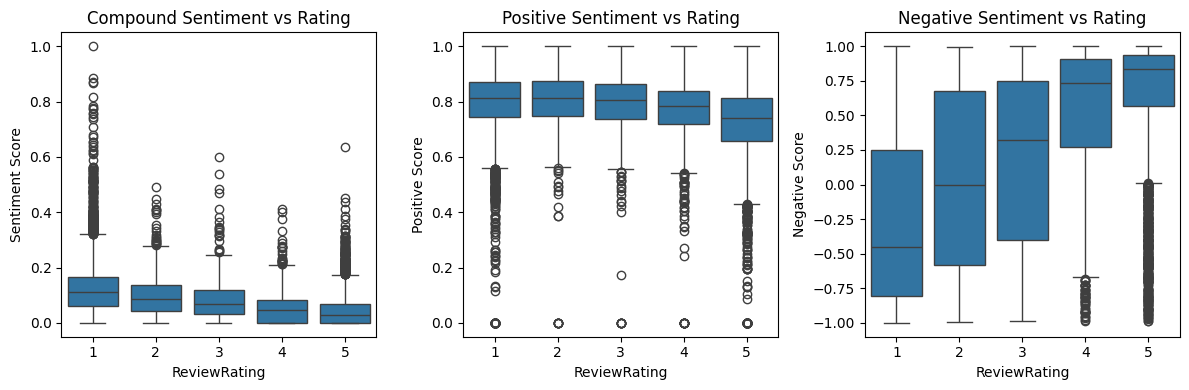

Correlation between sentiment and rating: -0.397
A negative correlation means that positive-sounding reviews are often linked to lower ratings,
suggesting that sentiment scores may not fully capture user intent in this dataset.


In [13]:
# =============================================================================
# Cell 13: Sentiment vs Rating Analysis
# =============================================================================

# Analyze relationship between sentiment and actual ratings
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.boxplot(data=df, x='ReviewRating', y='sentiment_compound')
plt.title('Compound Sentiment vs Rating')
plt.ylabel('Sentiment Score')

plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='ReviewRating', y='sentiment_pos')
plt.title('Positive Sentiment vs Rating')
plt.ylabel('Positive Score')

plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='ReviewRating', y='sentiment_neg')
plt.title('Negative Sentiment vs Rating')
plt.ylabel('Negative Score')

plt.tight_layout()
plt.show()

# Calculate correlation between sentiment and rating
sentiment_rating_corr = df['sentiment_compound'].corr(df['ReviewRating'])
print(f"Correlation between sentiment and rating: {sentiment_rating_corr:.3f}")
print("A negative correlation means that positive-sounding reviews are often linked to lower ratings,\n"\
"suggesting that sentiment scores may not fully capture user intent in this dataset.")

In [14]:
# =============================================================================
# Cell 14: Additional Text Features
# =============================================================================

def extract_text_features(text):
    """
    Extract additional features from text:
    - Word count
    - Character count
    - Sentence count
    - Average word length
    - Exclamation marks
    - Question marks
    - Capital letters ratio
    """
    if pd.isna(text):
        return {
            'word_count': 0,
            'char_count': 0,
            'sentence_count': 0,
            'avg_word_length': 0,
            'exclamation_count': 0,
            'question_count': 0,
            'capital_ratio': 0
        }
    
    text = str(text)
    
    # Basic counts
    word_count = len(text.split())
    char_count = len(text)
    sentence_count = len(re.split(r'[.!?]+', text))
    
    # Average word length
    words = text.split()
    avg_word_length = sum(len(word) for word in words) / len(words) if words else 0
    
    # Punctuation counts
    exclamation_count = text.count('!')
    question_count = text.count('?')
    
    # Capital letters ratio
    capital_count = sum(1 for c in text if c.isupper())
    capital_ratio = capital_count / len(text) if text else 0
    
    return {
        'word_count': word_count,
        'char_count': char_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'capital_ratio': capital_ratio
    }

# Extract text features
print("Extracting additional text features...")
text_features = df['ReviewText'].apply(extract_text_features)

# Convert to separate columns
feature_df = pd.DataFrame(text_features.tolist())
df = pd.concat([df, feature_df], axis=1)

print("Additional text features extracted!")
print(f"New feature columns: {feature_df.columns.tolist()}")

Extracting additional text features...
Additional text features extracted!
New feature columns: ['word_count', 'char_count', 'sentence_count', 'avg_word_length', 'exclamation_count', 'question_count', 'capital_ratio']


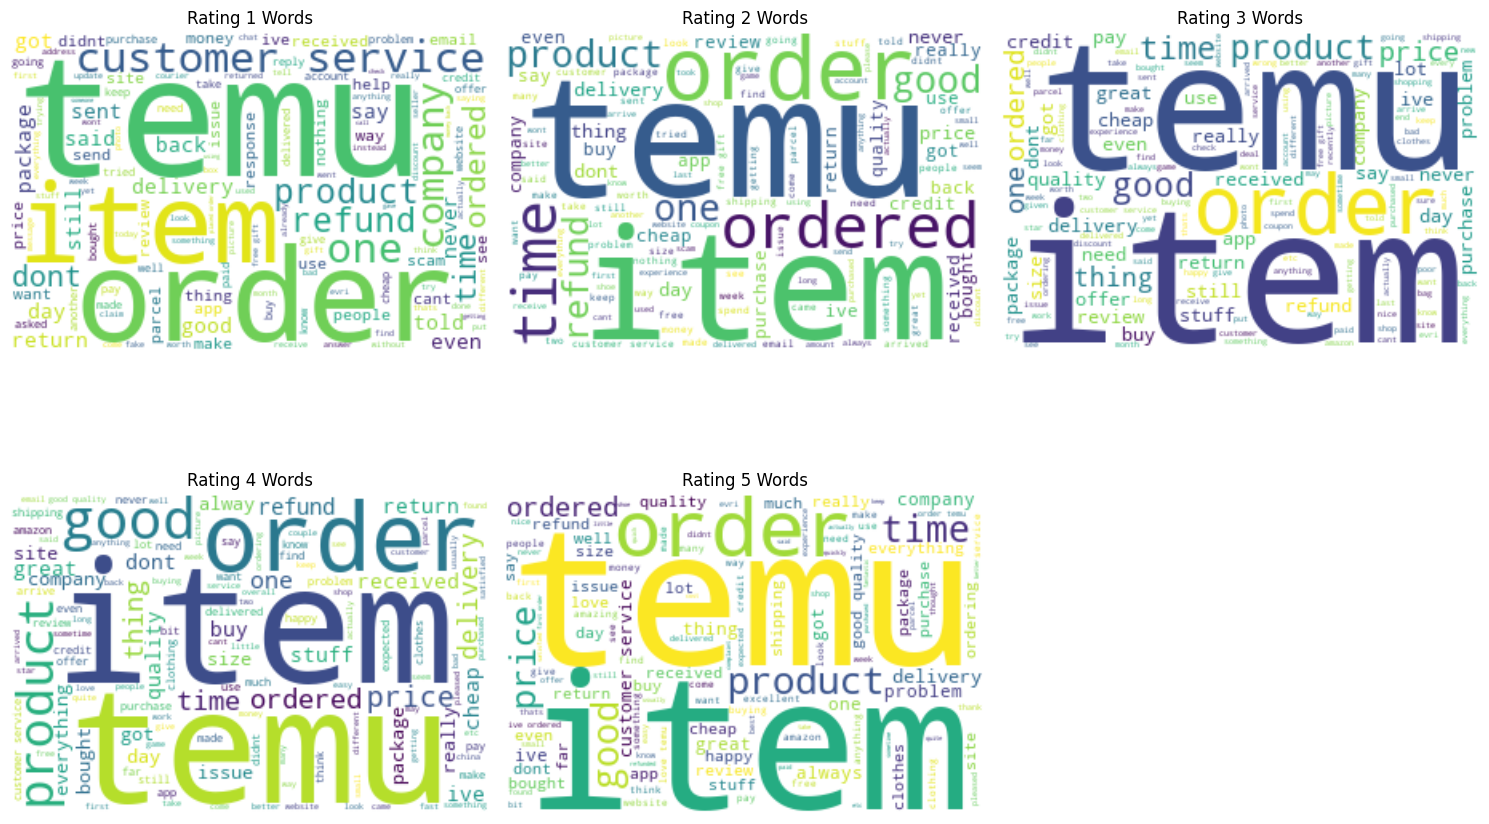

In [15]:
# =============================================================================
# Cell 15: Word Cloud Visualization
# =============================================================================

# Create word clouds for different ratings
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, rating in enumerate([1, 2, 3, 4, 5]):
    rating_text = ' '.join(df[df['ReviewRating'] == rating]['processed_text'].dropna())
    
    if rating_text:
        wordcloud = WordCloud(width=300, height=200, background_color='white').generate(rating_text)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'Rating {rating} Words')
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f'No data for rating {rating}', 
                    transform=axes[i].transAxes, ha='center', va='center')
        axes[i].set_title(f'Rating {rating} Words')
        axes[i].axis('off')

# Remove empty subplot
axes[5].remove()

plt.tight_layout()
plt.show()

Correlation of text features with rating:
ReviewRating         1.000000
sentiment_neg        0.585042
avg_word_length     -0.003850
capital_ratio       -0.082203
exclamation_count   -0.086832
question_count      -0.095364
sentence_count      -0.131826
word_count          -0.149758
char_count          -0.151540
sentiment_pos       -0.241718
Name: ReviewRating, dtype: float64


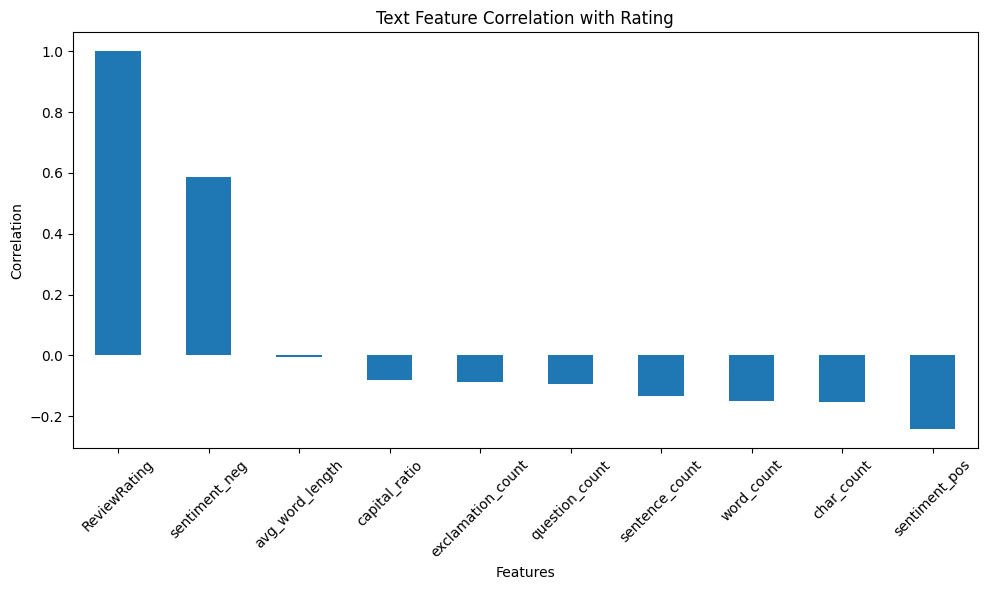

In [16]:
# =============================================================================
# Cell 16: Feature Correlation Analysis
# =============================================================================

# Analyze correlation between text features and rating
text_feature_cols = ['word_count', 'char_count', 'sentence_count', 'avg_word_length',
                     'exclamation_count', 'question_count', 'capital_ratio',
                     'sentiment_compound', 'sentiment_pos', 'sentiment_neg']

correlation_with_rating = df[text_feature_cols + ['ReviewRating']].corr()['ReviewRating'].sort_values(ascending=False)

print("Correlation of text features with rating:")
print(correlation_with_rating[:-1])  # Exclude self-correlation

# Visualize correlations
plt.figure(figsize=(10, 6))
correlation_with_rating[:-1].plot(kind='bar')
plt.title('Text Feature Correlation with Rating')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# =============================================================================
# Cell 17: Saving all preprocessing functions 
# =============================================================================
def calculate_sentiment_scores(text):
    """Calculate sentiment scores using NLTK SentimentIntensityAnalyzer"""
    scores = sia.polarity_scores(text)
    return {
        'sentiment_compound': scores['compound'],
        'sentiment_pos': scores['pos'],
        'sentiment_neu': scores['neu'],
        'sentiment_neg': scores['neg']
    }

def preprocess_single_text(text):
    """Complete preprocessing for a single text - same as your preprocessing pipeline"""
    # Use your existing preprocess_text function
    processed_text = preprocess_text(text)
    
    # Extract all features
    text_features = extract_text_features(text)
    sentiment_features = calculate_sentiment_scores(text)
    
    # Combine all features
    all_features = {
        'processed_text': processed_text,
        **text_features,
        **sentiment_features
    }
    
    return all_features

# =============================================================================
# Save the preprocessing functions and NLTK components
# =============================================================================
preprocessing_functions = {
    'clean_text': clean_text,
    'remove_special_chars': remove_special_chars, 
    'convert_emoji_to_sentiment': convert_emoji_to_sentiment,
    'tokenize_text': tokenize_text,
    'remove_stopwords': remove_stopwords,
    'lemmatize_tokens': lemmatize_tokens,
    'preprocess_text': preprocess_text,
    'extract_text_features': extract_text_features,
    'calculate_sentiment_scores': calculate_sentiment_scores,
    'preprocess_single_text': preprocess_single_text,
    'lemmatizer': lemmatizer,
    'sia': sia,
    'stop_words': stop_words
}

In [18]:
# =============================================================================
# Cell 16: Save Preprocessed Data
# =============================================================================

# Save preprocessed data for next steps - no replies needed
output_columns = ['UserId', 'UserName', 'UserCountry', 'ReviewCount', 'ReviewRating',
                  'ReviewTitle', 'ReviewText', 'processed_text', 'ReviewDate',
                  'word_count', 'char_count', 'sentence_count', 'avg_word_length',
                  'exclamation_count', 'question_count', 'capital_ratio',
                  'sentiment_compound', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']

df_processed = df[output_columns].copy()

# Save to CSV
df_processed.to_csv('../src/data/processed/temu_reviews_preprocessed.csv', index=False)

# Save to pkl and all needed functions for an instance api later
processed_data = {
    "df": df_processed,
    # Sentiment-Spalten als separates Array für spätere Notebooks
    "sentiment_scores": df_processed[
        ["sentiment_compound", "sentiment_pos",
         "sentiment_neu", "sentiment_neg"]
    ].to_dict(orient="list"),
    "preprocessing_functions": preprocessing_functions,
}

with open("../src/models/processed_data.pkl", "wb") as f:
    dill.dump(processed_data, f)

print("Preprocessed data saved!")
print(f"Final dataset shape: {df_processed.shape}")
print(f"Columns: {df_processed.columns.tolist()}")

Preprocessed data saved!
Final dataset shape: (13855, 20)
Columns: ['UserId', 'UserName', 'UserCountry', 'ReviewCount', 'ReviewRating', 'ReviewTitle', 'ReviewText', 'processed_text', 'ReviewDate', 'word_count', 'char_count', 'sentence_count', 'avg_word_length', 'exclamation_count', 'question_count', 'capital_ratio', 'sentiment_compound', 'sentiment_pos', 'sentiment_neu', 'sentiment_neg']


In [19]:
# =============================================================================
# Cell 17: Summary Statistics
# =============================================================================

print("\n" + "="*80)
print("TEXT PREPROCESSING SUMMARY:")
print("="*80)
print(f"Total reviews processed: {len(df_processed)}")
print(f"Average word count: {df_processed['word_count'].mean():.1f}")
print(f"Average sentiment score: {df_processed['sentiment_compound'].mean():.3f}")
print(f"Most correlated feature with rating: {correlation_with_rating.index[0]} ({correlation_with_rating.iloc[0]:.3f})")
print(f"Least correlated feature with rating: {correlation_with_rating.index[-2]} ({correlation_with_rating.iloc[-2]:.3f})")

# Check data quality
print(f"\nData Quality Check:")
print(f"Empty processed texts: {(df_processed['processed_text'].str.len() == 0).sum()}")
print(f"Missing values in key columns: {df_processed[['processed_text', 'ReviewRating']].isnull().sum().sum()}")

print("\nNext step: Feature engineering with TF-IDF vectors")


TEXT PREPROCESSING SUMMARY:
Total reviews processed: 13855
Average word count: 82.5
Average sentiment score: 0.091
Most correlated feature with rating: ReviewRating (1.000)
Least correlated feature with rating: sentiment_pos (-0.242)

Data Quality Check:
Empty processed texts: 132
Missing values in key columns: 0

Next step: Feature engineering with TF-IDF vectors
